## Using a simple Neural Network Model
#### - Building a neural network model using keras
#### - Using the Undersampled Data with Neural Net
#### - Using all the data and applying the same model

### Loading our data
### Using TF-IDF Model

In [1]:
import pandas as pd
import numpy as np
from nlp_train import tfidf_predict

In [2]:
train = pd.read_csv('ExportedData/train.csv')
test = pd.read_csv('ExportedData/test.csv')

In [3]:
X_train_tfidf = tfidf_predict(train.text.values)
y_train = train['airline_sentiment'].values
X_test_tfidf = tfidf_predict(test.text.values)
y_test = test['airline_sentiment'].values

In [4]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

### Bulding a Neural Network Model with TensorFlow

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential,regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [7]:
def dense_net(vocab_size):
    net = Sequential()
    net.add(Dense(64, activation = 'relu',input_shape = (vocab_size,),kernel_regularizer=regularizers.l2(l2=0.001)))
    net.add(BatchNormalization())
    net.add(Dropout(0.25))
    net.add(Dense(32,activation='relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1,activation='sigmoid'))
    return net

### Training the Model

In [8]:
def train_model(X_train,y_train, model):
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    history = model.fit(X_train,y_train, validation_split = 0.2, batch_size = 15, shuffle =True, verbose =2, epochs = 20,
         callbacks =[tf.keras.callbacks.EarlyStopping(patience=2)],
                       use_multiprocessing=True)
    return history

### Ploting our model metrics

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
def plot_model(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Training our Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                105600    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,969
Trainable params: 107,841
Non-trainable params: 128
________________________________________________

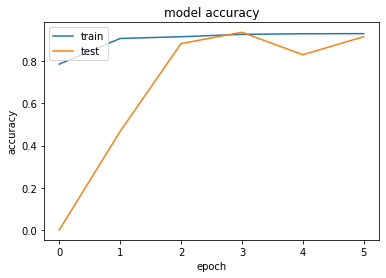

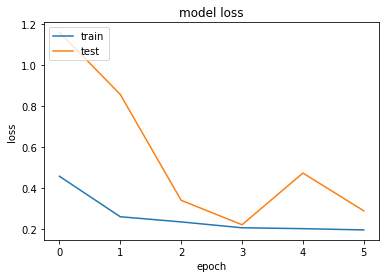

In [10]:
model = dense_net(vocab_size=len(X_train[1]))
model.summary()
his  = train_model(X_train,y_train, model=model)
plot_model(his)

## Testing with all the data

##### Here we take all the data to check whether my decision of imbalanced data was correct or wrong.

- This results are after fine tuning my model for a long time. 
- Initially the results I got are expected but after tweaking my model a little bit it out performed all my previous results


In [11]:
data = pd.read_csv('airline_sentiment_analysis.csv')

In [12]:
data['airline_sentiment'].replace('positive',0, inplace=True)
data['airline_sentiment'].replace('negative',1,inplace=True)

In [13]:
X = data['text'].values
y = data['airline_sentiment'].values

In [14]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y, test_size = 0.2, random_state=8)

In [15]:
rand_data = pd.DataFrame({'text':X_te,'airline_sentiment':y_te})
rand_data.to_csv('ranadom_data.csv')

In [16]:
from nlp_train import text_prepare
from sklearn.feature_extraction.text import TfidfVectorizer
X_tr = [text_prepare(x) for x in X_tr]
X_te = [text_prepare(x) for x in X_te]

#### Training a new TF-IDF Model
- Initially I skipped most of the data
- Here I am using all the data provided to me

In [17]:
def tfidf_train(X_train,X_test):
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 1))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test

In [18]:
X_tr_tfidf,X_ts_tfidf = tfidf_train(X_tr,X_te)

In [19]:
X_tr_np = X_tr_tfidf.toarray()
X_ts_np = X_ts_tfidf.toarray()

### Training

Epoch 1/20
493/493 - 1s - loss: 0.3738 - accuracy: 0.8539 - val_loss: 0.3143 - val_accuracy: 0.8641
Epoch 2/20
493/493 - 1s - loss: 0.2874 - accuracy: 0.8944 - val_loss: 0.2630 - val_accuracy: 0.9004
Epoch 3/20
493/493 - 1s - loss: 0.2794 - accuracy: 0.8990 - val_loss: 0.2616 - val_accuracy: 0.9020
Epoch 4/20
493/493 - 1s - loss: 0.2792 - accuracy: 0.9012 - val_loss: 0.2669 - val_accuracy: 0.8960
Epoch 5/20
493/493 - 1s - loss: 0.2727 - accuracy: 0.9013 - val_loss: 0.2750 - val_accuracy: 0.8977


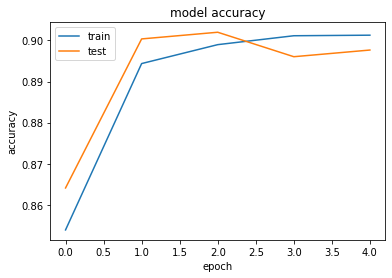

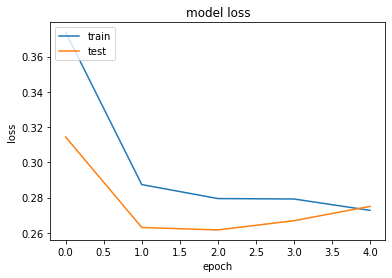

In [20]:
model_all = dense_net(vocab_size=len(X_tr_np[1]))
his = train_model(X_train=X_tr_np,y_train=y_tr,model=model_all)
plot_model(his)

### Predicting and Comparing the results

- We had taken twos sets of data from the same dataset.
- Comparing the results
- What I had learned so far

In [36]:
y_pred = model_all.predict(X_ts_np)

In [37]:
def sigmoid(x):
    if x>0.5:
        return 1
    else:
        return 0
y_pred = [sigmoid(i) for i in y_pred]

In [39]:
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, f1_score
def test_metrics(y_test,y_pred):
    print("Confusion Matrix \n",cm(y_test,y_pred))
    print("F1 score \n",f1_score(y_test,y_pred))

### Using the Undersampled Data for prediction

In [42]:
y_real = model.predict(X_test)
y_real = [sigmoid(i) for i in y_real]
test_metrics(y_test,y_real)

Confusion Matrix 
 [[324  39]
 [ 53 310]]
F1 score 
 0.8707865168539326


### Using the sample data

In [41]:
test_metrics(y_te,y_pred)

Confusion Matrix 
 [[ 311  169]
 [  31 1798]]
F1 score 
 0.9473129610115912


### Results

- Choosing more data helps your model to learn more but it overfits agressively. Avoiding Overfitting results in  a good model.
- Using UnderSampled data also resulted in a descent performance model. Also avoided bias of the model.

### Conclusion

- In the initial steps on this project I had seen that data is more tend towards the negative tweets and some words are commonly used in both positive and negative tweets.
- In choosing Machine Learning I wanted to go with a linear and a probalistic model. The results there are very similar.
- While going with Deep Learning model, I tried different models like Simple neural network, LSTM, Bidirectional LSTM. But the training times on them is so huge. With a Simple neural network model I acheived better results.

### Choosing the quantity of data really depends on the target values. 
If there is a huge amount of data.